In [4]:
# Robust project bootstrap (works from notebooks/ or project root)
import sys, os, pathlib, subprocess

def find_project_root(start: pathlib.Path) -> pathlib.Path:
    """Walk up until we find 'src/sql/load_qe_data.py' (project root)."""
    p = start.resolve()
    for _ in range(5):  # walk up to 5 levels just in case
        if (p / "src" / "sql" / "load_qe_data.py").exists():
            return p
        p = p.parent
    raise FileNotFoundError("Could not locate project root with src/sql/load_qe_data.py")

# 1) Locate and cd to project root
nb_dir = pathlib.Path.cwd()
root = find_project_root(nb_dir)
os.chdir(root)

# 2) Build DB if missing
db_path = pathlib.Path("data/qe.db")
if not db_path.exists():
    print("[INFO] data/qe.db not found — building now…")
    subprocess.run([sys.executable, "src/sql/load_qe_data.py"], check=True)
else:
    print("[OK] data/qe.db already present.")

# 3) Diagnostics
print("Project root:", pathlib.Path.cwd())
print("Python:", sys.executable)
print("Python version:", sys.version.split()[0])
print("Has DB?", db_path.exists())

[OK] data/qe.db already present.
Project root: /Users/sultanmuhammad/Documents/GitHub Projects/quality-enhancement-analytics
Python: /Users/sultanmuhammad/miniconda/envs/qe/bin/python
Python version: 3.11.13
Has DB? True


In [5]:
import sqlite3, pandas as pd, pathlib
assert pathlib.Path("data/qe.db").exists(), "DB missing — run the builder script first."
conn = sqlite3.connect("data/qe.db")

print(pd.read_sql("SELECT COUNT(*) AS n_students FROM students;", conn))
print(pd.read_sql("SELECT COUNT(*) AS n_modules FROM modules;", conn))
conn.close()

   n_students
0        1200
   n_modules
0        120


In [6]:
import sqlite3, pandas as pd
pd.set_option("display.max_columns", 50)

conn = sqlite3.connect("data/qe.db")

# List tables
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn)

,name
0,admissions
1,assessments
2,complaints
3,enrolments
4,grades
5,modules
6,placements
7,students
8,support_usage
9,surveys


In [7]:
# Peek core tables
for t in ["students","admissions","modules","enrolments","assessments","grades","surveys"]:
    print(f"\n--- {t} (5 rows)")
    display(pd.read_sql(f"SELECT * FROM {t} LIMIT 5;", conn))


--- students (5 rows)


,student_id,programme,intake,wp_flag,age_band,gender
0,1,Physiotherapy,2023-Sep,0,21-24,F
1,2,Nursing,2023-Sep,1,<21,F
2,3,PublicHealth,2024-Jan,1,21-24,F
3,4,Physiotherapy,2024-Jan,1,<21,F
4,5,Pharmacy,2023-Sep,1,25-34,M



--- admissions (5 rows)


,app_id,student_id,route,offer_status,decision_date
0,1,1,Domestic,Offer,2023-04-21
1,2,2,Domestic,Offer,2023-04-30
2,3,3,Domestic,Offer,2023-05-13
3,4,4,Domestic,Waitlist,2023-03-21
4,5,5,Domestic,Offer,2023-05-21



--- modules (5 rows)


,module_id,programme,term,credits
0,1,Pharmacy,2023-Fall,17
1,2,Pharmacy,2023-Fall,18
2,3,Pharmacy,2023-Fall,11
3,4,Pharmacy,2023-Fall,12
4,5,Pharmacy,2023-Fall,10



--- enrolments (5 rows)


,student_id,module_id,term
0,1,75,2023-Fall
1,1,74,2023-Fall
2,1,76,2023-Fall
3,1,78,2023-Fall
4,1,73,2023-Fall



--- assessments (5 rows)


,assessment_id,module_id,type,due_date,weight,returned_date
0,1,1,CW1,2024-07-20,0.306317,2024-08-10
1,2,1,CW2,2023-10-11,0.352714,2023-10-23
2,3,1,Exam,2024-11-24,0.274189,2024-12-09
3,4,2,CW1,2024-08-14,0.393239,2024-09-07
4,5,2,CW2,2025-03-04,0.248443,2025-03-23



--- grades (5 rows)


,student_id,assessment_id,score_pct
0,1,223,64.092381
1,1,224,74.968170
2,1,225,58.256981
3,1,220,89.794035
4,1,221,72.630704



--- surveys (5 rows)


,survey_id,module_id,term,theme,qaa_theme,mean_score_1_5,responses
0,1,1,2023-Fall,Admissions,"Admissions, Recruitment and Widening Access",3.29,164
1,2,1,2023-Fall,Assessment,Assessment,4.23,201
2,3,1,2023-Fall,LearningTeaching,Learning and Teaching,4.23,123
3,4,1,2023-Fall,StudentSupport,Enabling Student Achievement,3.46,166
4,5,1,2023-Fall,Monitoring,Monitoring and Evaluation,3.35,107


In [8]:
students = pd.read_sql("SELECT * FROM students;", conn)
students.loc[students.sample(frac=0.01, random_state=42).index, "gender"] = "female"   # lowercase variant
students.loc[students.sample(frac=0.01, random_state=43).index, "age_band"] = None     # missing

surveys = pd.read_sql("SELECT * FROM surveys;", conn)
surveys.loc[surveys.sample(frac=0.005, random_state=44).index, "mean_score_1_5"] = None

assessments = pd.read_sql("SELECT * FROM assessments;", conn)

In [9]:
# Gender tidy -> 'F','M','Other/NA'
gender_map = {"female":"F","Female":"F","F":"F","male":"M","Male":"M","M":"M"}
students["gender_clean"] = students["gender"].map(gender_map).fillna("Other/NA")

# Age_band: fill missing with mode
mode_age = students["age_band"].mode(dropna=True)[0]
students["age_band_clean"] = students["age_band"].fillna(mode_age)

# Surveys: fill small missing share with theme median
surveys["mean_score_1_5"] = surveys.groupby("qaa_theme")["mean_score_1_5"]\
    .transform(lambda s: s.fillna(s.median()))

students.head(), surveys.head()

(   student_id      programme    intake  wp_flag age_band gender gender_clean  \
 0           1  Physiotherapy  2023-Sep        0    21-24      F            F   
 1           2        Nursing  2023-Sep        1      <21      F            F   
 2           3   PublicHealth  2024-Jan        1    21-24      F            F   
 3           4  Physiotherapy  2024-Jan        1      <21      F            F   
 4           5       Pharmacy  2023-Sep        1    25-34      M            M   
 
   age_band_clean  
 0          21-24  
 1            <21  
 2          21-24  
 3            <21  
 4          25-34  ,
    survey_id  module_id       term             theme  \
 0          1          1  2023-Fall        Admissions   
 1          2          1  2023-Fall        Assessment   
 2          3          1  2023-Fall  LearningTeaching   
 3          4          1  2023-Fall    StudentSupport   
 4          5          1  2023-Fall        Monitoring   
 
                                      qaa_theme

In [10]:
# 4.1 Assessment turnaround (days) + bins
turn = pd.read_sql("""
SELECT assessment_id,
       julianday(returned_date) - julianday(due_date) AS turnaround_days
FROM assessments;
""", conn)

turn["turn_bin"] = pd.cut(
    turn["turnaround_days"],
    bins=[-1,10,15,20,999],
    labels=["<=10","11-15","16-20",">20"]
)
turn.head()

,assessment_id,turnaround_days,turn_bin
0,1,21.0,>20
1,2,12.0,11-15
2,3,15.0,11-15
3,4,24.0,>20
4,5,19.0,16-20


In [11]:
# 4.2 Programme/term pass rate
prog_pass = pd.read_sql("""
WITH agg AS (
  SELECT m.programme, m.term, e.module_id, g.student_id, AVG(g.score_pct) AS mavg
  FROM enrolments e
  JOIN assessments a ON a.module_id=e.module_id
  JOIN grades g ON g.assessment_id=a.assessment_id AND g.student_id=e.student_id
  JOIN modules m ON m.module_id=e.module_id
  GROUP BY m.programme, m.term, e.module_id, g.student_id
)
SELECT programme, term, ROUND(AVG(mavg >= 50)*100,1) AS pass_rate_pct,
       COUNT(DISTINCT student_id) AS students
FROM agg
GROUP BY programme, term
ORDER BY programme, term;
""", conn)
prog_pass.head()

,programme,term,pass_rate_pct,students
0,Medicine,2023-Fall,99.6,159
1,Medicine,2024-Fall,99.8,229
2,Medicine,2024-Spring,99.5,229
3,Medicine,2025-Spring,99.6,229
4,Nursing,2023-Fall,99.6,205


In [12]:
# 4.3 Engagement index: mean survey (1–5) × log(1 + median support visits per term)
support = pd.read_sql("SELECT * FROM support_usage;", conn)
mod_theme = pd.read_sql("""
SELECT m.programme, s.module_id, s.term, s.qaa_theme, s.mean_score_1_5
FROM surveys s JOIN modules m ON m.module_id=s.module_id;
""", conn)

import numpy as np
eng = mod_theme.groupby(["programme","term"], observed=True)\
               .mean(numeric_only=True).reset_index()

med_visits = support.groupby("term", observed=True)["visits"].median().reindex(eng["term"]).values
eng["engagement_index"] = eng["mean_score_1_5"] * np.log1p(np.where(np.isnan(med_visits), 0, med_visits))
eng.head()

,programme,term,module_id,mean_score_1_5,engagement_index
0,Medicine,2023-Fall,51.5,3.846111,4.225385
1,Medicine,2024-Fall,63.5,3.901389,4.286114
2,Medicine,2024-Spring,57.5,4.031111,4.428628
3,Medicine,2025-Spring,69.5,3.920278,4.306865
4,Nursing,2023-Fall,27.5,3.849722,4.229352


In [13]:
# Pass rate by module
mod_pass = pd.read_sql("""
WITH per_stu_mod AS (
  SELECT e.module_id, e.student_id, AVG(g.score_pct) AS mavg
  FROM enrolments e
  JOIN assessments a ON a.module_id=e.module_id
  JOIN grades g ON g.assessment_id=a.assessment_id AND g.student_id=e.student_id
  GROUP BY e.module_id, e.student_id
)
SELECT module_id, ROUND(AVG(mavg >= 50)*100,1) AS pass_rate
FROM per_stu_mod
GROUP BY module_id;
""", conn)

# Survey mean by module (Assessment & Learning/Teaching)
mod_svy = pd.read_sql("""
SELECT module_id, AVG(mean_score_1_5) AS mean_survey
FROM surveys
WHERE qaa_theme IN ('Assessment','Learning and Teaching')
GROUP BY module_id;
""", conn)

risk = mod_pass.merge(mod_svy, on="module_id", how="inner")
risk["at_risk"] = (risk["pass_rate"] < 70) & (risk["mean_survey"] < 3.5)
risk_summary = risk.sort_values(["at_risk","pass_rate","mean_survey"]).reset_index(drop=True)
risk_summary.head()

,module_id,pass_rate,mean_survey,at_risk
0,76,97.7,4.210,False
1,101,97.9,3.920,False
2,57,98.4,4.125,False
3,93,98.5,3.885,False
4,11,98.6,3.795,False


In [14]:
from pathlib import Path
outdir = Path("reports/figures"); outdir.mkdir(parents=True, exist_ok=True)

prog_pass[["programme","term","students","pass_rate_pct"]].to_csv(outdir/"kpi_pass_rate.csv", index=False)
turn[["assessment_id","turnaround_days","turn_bin"]].to_csv(outdir/"assessment_turnaround_bins.csv", index=False)
eng[["programme","term","mean_score_1_5","engagement_index"]].to_csv(outdir/"engagement_index.csv", index=False)
risk_summary[["module_id","pass_rate","mean_survey","at_risk"]].to_csv(outdir/"at_risk_modules.csv", index=False)

sorted(p.name for p in outdir.glob("*.csv"))

['assessment_turnaround_bins.csv',
 'at_risk_modules.csv',
 'engagement_index.csv',
 'kpi_pass_rate.csv']

In [15]:
import matplotlib.pyplot as plt

# Pass rate trend per programme
for prog in sorted(prog_pass.programme.unique()):
    d = prog_pass[prog_pass.programme == prog]
    plt.figure()
    plt.plot(d["term"], d["pass_rate_pct"], marker="o")
    plt.title(f"Pass rate trend — {prog}")
    plt.xlabel("Term"); plt.ylabel("Pass rate (%)")
    plt.xticks(rotation=45); plt.tight_layout()
    plt.savefig(outdir / f"pass_rate_trend_{prog}.png")
    plt.close()

# Turnaround distribution (by bins)
plt.figure()
turn["turn_bin"].value_counts().sort_index().plot(kind="bar")
plt.title("Assessment turnaround distribution")
plt.xlabel("Days bin"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig(outdir / "turnaround_distribution.png")
plt.close()

In [16]:
# Scatter: Module-level pass rate vs survey satisfaction
plt.figure(figsize=(6,4))
plt.scatter(risk_summary["mean_survey"], risk_summary["pass_rate"],
            c=risk_summary["at_risk"].map({True:"red", False:"green"}), alpha=0.6)
plt.xlabel("Mean survey score (1–5)")
plt.ylabel("Pass rate (%)")
plt.title("Module outcomes: pass rate vs survey satisfaction")
plt.grid(True)
plt.tight_layout()
plt.savefig(outdir / "scatter_pass_vs_survey.png")
plt.close()

# Scatter: Engagement index vs pass rate (programme/term level)
merged = prog_pass.merge(eng, on=["programme","term"], how="left")
plt.figure(figsize=(6,4))
plt.scatter(merged["engagement_index"], merged["pass_rate_pct"], alpha=0.7)
for _, row in merged.iterrows():
    plt.text(row["engagement_index"], row["pass_rate_pct"], row["programme"], fontsize=7)
plt.xlabel("Engagement index")
plt.ylabel("Pass rate (%)")
plt.title("Programme/term: Engagement vs Pass rate")
plt.grid(True)
plt.tight_layout()
plt.savefig(outdir / "scatter_engagement_vs_pass.png")
plt.close()

In [17]:
conn.close()

In [18]:
from pathlib import Path
outdir = Path("reports/figures")
outdir.mkdir(parents=True, exist_ok=True)

# Recreate KPI outputs from Step 2
prog_pass[["programme","term","students","pass_rate_pct"]].to_csv(outdir/"kpi_pass_rate.csv", index=False)
turn[["assessment_id","turnaround_days","turn_bin"]].to_csv(outdir/"assessment_turnaround_bins.csv", index=False)
eng[["programme","term","mean_score_1_5","engagement_index"]].to_csv(outdir/"engagement_index.csv", index=False)
risk_summary[["module_id","pass_rate","mean_survey","at_risk"]].to_csv(outdir/"at_risk_modules.csv", index=False)

print("CSV files saved:", sorted(p.name for p in outdir.glob("*.csv")))

CSV files saved: ['assessment_turnaround_bins.csv', 'at_risk_modules.csv', 'engagement_index.csv', 'kpi_pass_rate.csv']


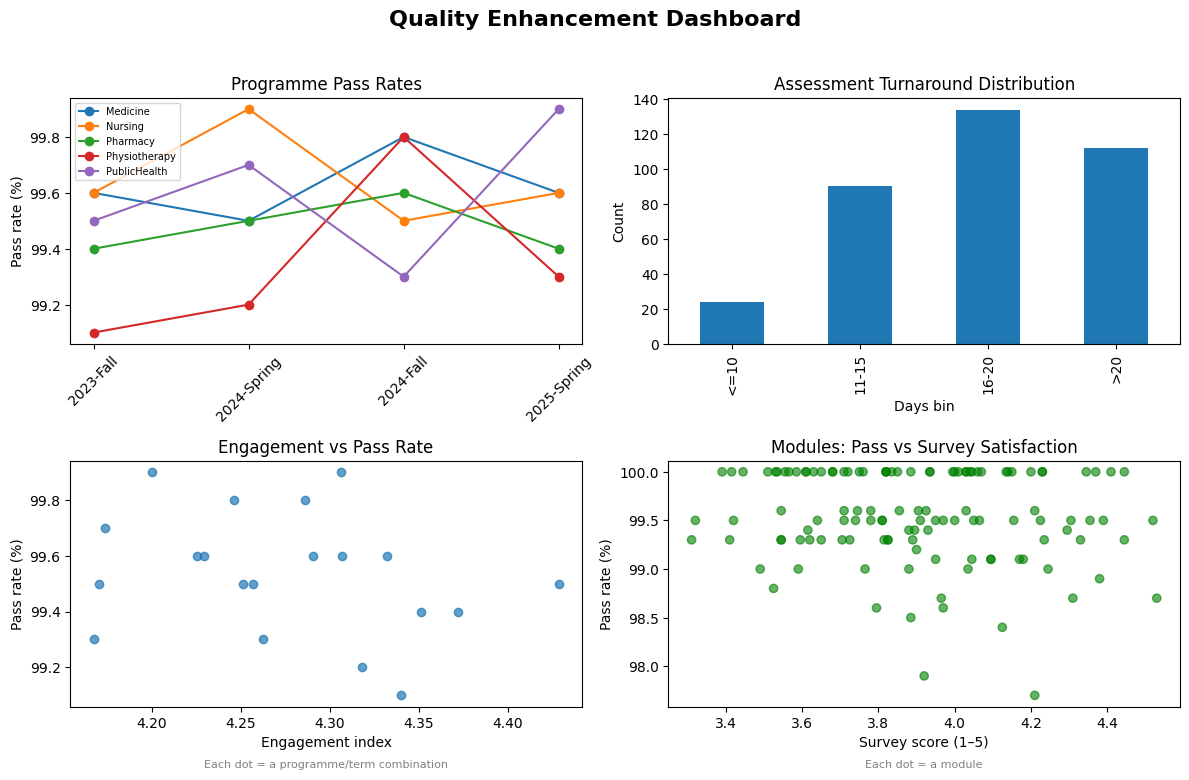

In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# Ensure output folder exists
outdir = Path("reports/figures")
outdir.mkdir(parents=True, exist_ok=True)

# (Re)load CSVs just in case
prog_pass = pd.read_csv(outdir/"kpi_pass_rate.csv")
turn      = pd.read_csv(outdir/"assessment_turnaround_bins.csv")
eng       = pd.read_csv(outdir/"engagement_index.csv")
risk      = pd.read_csv(outdir/"at_risk_modules.csv")

# Make 'term' a categorical so lines sort correctly (edit the order if yours differs)
term_order = ["2023-Fall","2024-Spring","2024-Fall","2025-Spring"]
prog_pass["term"] = pd.Categorical(prog_pass["term"], categories=term_order, ordered=True)

# ---- FIX: join engagement to pass-rate for the scatter
merged = prog_pass.merge(eng[["programme","term","engagement_index"]],
                         on=["programme","term"], how="left")

# Create dashboard
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Quality Enhancement Dashboard", fontsize=16, fontweight="bold")

# 1) Programme Pass Rate (line)
for prog in sorted(prog_pass["programme"].unique()):
    d = prog_pass[prog_pass["programme"] == prog].sort_values("term")
    axes[0,0].plot(d["term"], d["pass_rate_pct"], marker="o", label=prog)
axes[0,0].set_title("Programme Pass Rates")
axes[0,0].set_ylabel("Pass rate (%)")
axes[0,0].tick_params(axis="x", rotation=45)
axes[0,0].legend(fontsize=7)

# 2) Assessment Turnaround (bar) — order the bins
bin_order = ["<=10","11-15","16-20",">20"]
turn["turn_bin"] = pd.Categorical(turn["turn_bin"], categories=bin_order, ordered=True)
turn["turn_bin"].value_counts().sort_index().plot(kind="bar", ax=axes[0,1])
axes[0,1].set_title("Assessment Turnaround Distribution")
axes[0,1].set_xlabel("Days bin")
axes[0,1].set_ylabel("Count")

# 3) Engagement vs Pass (scatter)
axes[1,0].scatter(merged["engagement_index"], merged["pass_rate_pct"], alpha=0.7)
axes[1,0].set_title("Engagement vs Pass Rate")
axes[1,0].set_xlabel("Engagement index")
axes[1,0].set_ylabel("Pass rate (%)")
axes[1,0].text(0.5, -0.25, "Each dot = a programme/term combination",
               transform=axes[1,0].transAxes, ha="center", fontsize=8, color="gray")

# 4) At-risk modules (scatter)
colors = risk["at_risk"].map({True: "red", False: "green"})
axes[1,1].scatter(risk["mean_survey"], risk["pass_rate"], c=colors, alpha=0.6)
axes[1,1].set_title("Modules: Pass vs Survey Satisfaction")
axes[1,1].set_xlabel("Survey score (1–5)")
axes[1,1].set_ylabel("Pass rate (%)")
axes[1,1].text(0.5, -0.25, "Each dot = a module",
               transform=axes[1,1].transAxes, ha="center", fontsize=8, color="gray")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(outdir/"dashboard_overview.png", dpi=150)
plt.show()


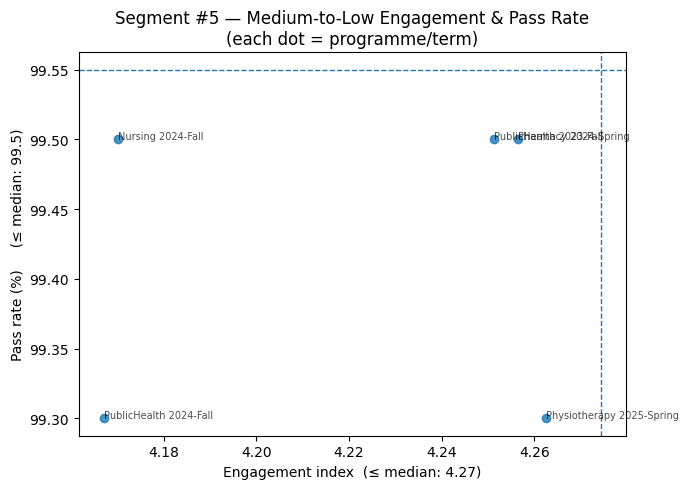

[#5] programme/term points in segment: 5 of 20


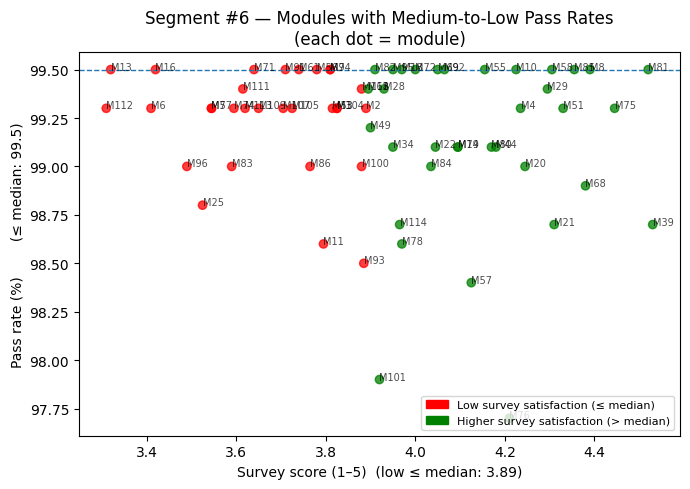

[#6] modules in segment: 65 of 120


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

outdir = Path("reports/figures"); outdir.mkdir(parents=True, exist_ok=True)

# ---------- Graph #5: Medium-to-low ENGAGEMENT & PASS (programme/term) ----------
cut_eng = merged["engagement_index"].median()
cut_pass_prog = merged["pass_rate_pct"].median()

seg5 = merged[(merged["engagement_index"] <= cut_eng) &
              (merged["pass_rate_pct"]  <= cut_pass_prog)].copy()

plt.figure(figsize=(7,5))
plt.scatter(seg5["engagement_index"], seg5["pass_rate_pct"], alpha=0.8)

# add programme + term labels
for _, row in seg5.iterrows():
    plt.text(row["engagement_index"], row["pass_rate_pct"], 
             f"{row['programme']} {row['term']}", fontsize=7, alpha=0.7)

plt.title("Segment #5 — Medium-to-Low Engagement & Pass Rate\n(each dot = programme/term)")
plt.xlabel(f"Engagement index  (≤ median: {cut_eng:.2f})")
plt.ylabel(f"Pass rate (%)     (≤ median: {cut_pass_prog:.1f})")
plt.axvline(cut_eng, linestyle="--", linewidth=1)
plt.axhline(cut_pass_prog, linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig(outdir/"segment_5_mediumlow_engagement_pass_labeled.png", dpi=150)
plt.show()

print(f"[#5] programme/term points in segment: {len(seg5)} of {len(merged)}")

# ---------- Graph #6: Medium-to-low PASS (modules) ----------
cut_pass_mod = risk["pass_rate"].median()
low_svy_cut = risk["mean_survey"].median()

seg6 = risk[risk["pass_rate"] <= cut_pass_mod].copy()
colors = np.where(seg6["mean_survey"] <= low_svy_cut, "red", "green")

plt.figure(figsize=(7,5))
scatter = plt.scatter(seg6["mean_survey"], seg6["pass_rate"], c=colors, alpha=0.75)

# Add module IDs
for _, row in seg6.iterrows():
    plt.text(row["mean_survey"], row["pass_rate"], 
             f"M{row['module_id']}", fontsize=7, alpha=0.7)

plt.title("Segment #6 — Modules with Medium-to-Low Pass Rates\n(each dot = module)")
plt.xlabel(f"Survey score (1–5)  (low ≤ median: {low_svy_cut:.2f})")
plt.ylabel(f"Pass rate (%)        (≤ median: {cut_pass_mod:.1f})")
plt.axhline(cut_pass_mod, linestyle="--", linewidth=1)

# Legend for red/green
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Low survey satisfaction (≤ median)')
green_patch = mpatches.Patch(color='green', label='Higher survey satisfaction (> median)')
plt.legend(handles=[red_patch, green_patch], loc="lower right", fontsize=8)

plt.tight_layout()
plt.savefig(outdir/"segment_6_mediumlow_module_pass_labeled.png", dpi=150)
plt.show()

print(f"[#6] modules in segment: {len(seg6)} of {len(risk)}")